<a href="https://colab.research.google.com/github/movefutures/test/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 2 Project**

이번 프로젝트에서는 다양한 국제 주요 선물상품으로 KOSPI 지수를 예측하는 모델을 만들고 이에 대한 해석을 브리핑해보겠습니다.

가정 1. 주요 상품들의 가격변동이 KOSPI의 변동율에 어떤 영향을 줄까?

가정 2. 주요 상품들의 가격추이가 KOSPI 포인트에 어떤 영향을 미칠까?

**목적 >> 가정들의 결론을 토대로 KOSPI지수 예측**

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. 데이터선택**

KOSPI 1981.5.1~2022.1.10

DowJones 1980.1.2~2022.1.7

WTI유 1983.3.31~2022.1.10

Gold 1980.1.1~2022.1.6

In [48]:
filename1 = '/content/sample_data/DowJones 1980.1.2_2022.1.7.csv'
filename2 = '/content/sample_data/KOSPI 1981.5.1_2022.1.10.csv'
filename3 = '/content/sample_data/WTI유 선물 1983.3.31_2022.1.10.csv' 
filename4 = '/content/sample_data/금 선물 1980.1.1_2022.1.6.csv' 

In [49]:
#파일 불러오기
import pandas as pd
import numpy as np
import datetime

data1 = pd.read_csv(filename1)
data2 = pd.read_csv(filename2)
data3 = pd.read_csv(filename3)
data4 = pd.read_csv(filename4)

#일자데이터가 공통으로 존재하는 값들을 제외한 데이터는 삭제
cut_lately = pd.to_datetime('2022-01-06')
cut_past = pd.to_datetime('1983-03-31')

def chan_(df):
  #날짜열 형식 일치
  df['날짜']=df['날짜'].replace(to_replace='년 ', value='-', regex=True)    
  df['날짜']=df['날짜'].replace(to_replace='월 ', value='-', regex=True)      
  df['날짜']=df['날짜'].replace(to_replace='일', value='', regex=True)
  
  #날짜 데이터로 변환
  df['날짜']=pd.to_datetime(df['날짜'])
  return df

data1=chan_(data1)
data2=chan_(data2)
data3=chan_(data3)
data4=chan_(data4)

data=pd.merge(data1, data3, on = '날짜', how = 'inner')
data=pd.merge(data, data4, on = '날짜', how = 'inner')
data=pd.merge(data, data2, on = '날짜', how = 'inner')

data

,날짜,Dow_C,Dow_O,Dow_H,Dow_L,Dow_V,Dow_per,Cru_C,Cru_O,Cru_H,Cru_L,Cru_V,Cru_per,Gold_C,Gold_O,Gold_H,Gold_L,Gold_V,Gold_per,KOS_C,KOS_O,KOS_H,KOS_L,KOS_V,KOS_per
0,2022-01-06,"36,236.34","36,409.05","36,463.47","36,201.25",377.09M,-0.47%,79.46,77.24,80.24,76.73,476.67K,2.07%,"1,789.20","1,810.60","1,811.60","1,785.40",238.64K,-1.97%,"2,920.53","2,925.40","2,952.54","2,915.38",786.04M,-1.13%
1,2022-01-05,"36,407.30","36,795.40","36,952.53","36,400.42",450.29M,-1.07%,77.85,77.18,78.58,76.51,397.90K,1.12%,"1,825.10","1,815.20","1,830.70","1,808.20",173.34K,0.58%,"2,953.97","2,984.05","2,986.20","2,936.73",787.35M,-1.18%
2,2022-01-04,"36,799.39","36,636.00","36,933.78","36,636.00",421.70M,0.59%,76.99,76.02,77.64,75.70,372.85K,1.20%,"1,814.60","1,801.10","1,817.20","1,798.10",167.71K,0.81%,"2,989.24","2,991.97","2,995.25","2,973.08",621.55M,0.02%
3,2022-01-03,"36,584.94","36,418.94","36,595.77","36,246.45",329.56M,0.68%,76.08,75.69,76.46,74.27,317.63K,1.16%,"1,800.10","1,830.10","1,833.00","1,798.20",168.31K,-1.56%,"2,988.77","2,998.32","3,010.77","2,979.42",435.82M,0.37%
4,2021-12-30,"36,398.08","36,558.11","36,679.09","36,372.13",197.77M,-0.25%,76.99,76.58,77.44,75.78,231.16K,0.56%,"1,814.10","1,805.60","1,818.10","1,796.20",113.43K,0.46%,"2,977.65","2,999.75","3,005.36","2,975.74",461.04M,-0.52%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9211,1983-04-08,"1,124.71","1,117.55","1,124.81","1,113.20",-,0.63%,30.38,30.65,30.65,30.25,0.37K,0.70%,421.7,422,425.5,421,1.02K,-0.87%,120.08,120.08,120.08,120.08,1.23M,0.50%
9212,1983-04-07,"1,117.65","1,112.52","1,117.36","1,111.55",-,0.37%,30.17,29.92,30.20,29.86,0.82K,0.90%,425.4,428,428.5,425,0.54K,-0.98%,119.48,119.48,119.48,119.48,1.13M,-0.13%
9213,1983-04-06,"1,113.49","1,122.77","1,122.77","1,104.68",-,-0.60%,29.90,29.90,29.92,29.65,0.39K,0.64%,429.6,430.5,430.8,425.5,1.29K,0.19%,119.64,119.64,119.64,119.64,834.00K,-0.05%
9214,1983-04-04,"1,127.61","1,129.84","1,129.84","1,121.90",-,-0.21%,29.44,29.30,29.70,29.29,0.16K,0.58%,427.5,417,429,417,2.45K,2.79%,119.7,119.7,119.7,119.7,825.00K,-0.30%


# 가정 1. 주요 상품들의 가격변동이 KOSPI의 가격에 어떤 영향을 줄까?

In [33]:
#전일대비 주요 상품들의 변동퍼센티지를 통해 KOSPI 지수 변동률과의 관계를 확인 

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


dow_vali=pd.DataFrame(data['Dow_per'])
gol_vali=pd.DataFrame(data['Gold_per'])
cru_vali=pd.DataFrame(data['Cru_per'])
kos_vali=pd.DataFrame(data['KOS_per'])

#전일대비 percentage 칼럼만 따로 취합 후 형변환
percentage=pd.concat([dow_vali, gol_vali, cru_vali, kos_vali], axis=1)
percentage.replace(to_replace='%', value='', regex=True, inplace=True)
percentage=percentage.astype(np.float)

#상승률 0인 값들은 전부 제거
percentage = percentage.replace(to_replace='0.00', value=np.NaN, regex=True)
percentage = percentage.dropna()

percentage.corr()


,Dow_per,Gold_per,Cru_per,KOS_per
Dow_per,1.000000,-0.037723,0.089790,0.122612
Gold_per,-0.037723,1.000000,0.081435,0.020483
Cru_per,0.089790,0.081435,1.000000,0.026479
KOS_per,0.122612,0.020483,0.026479,1.000000


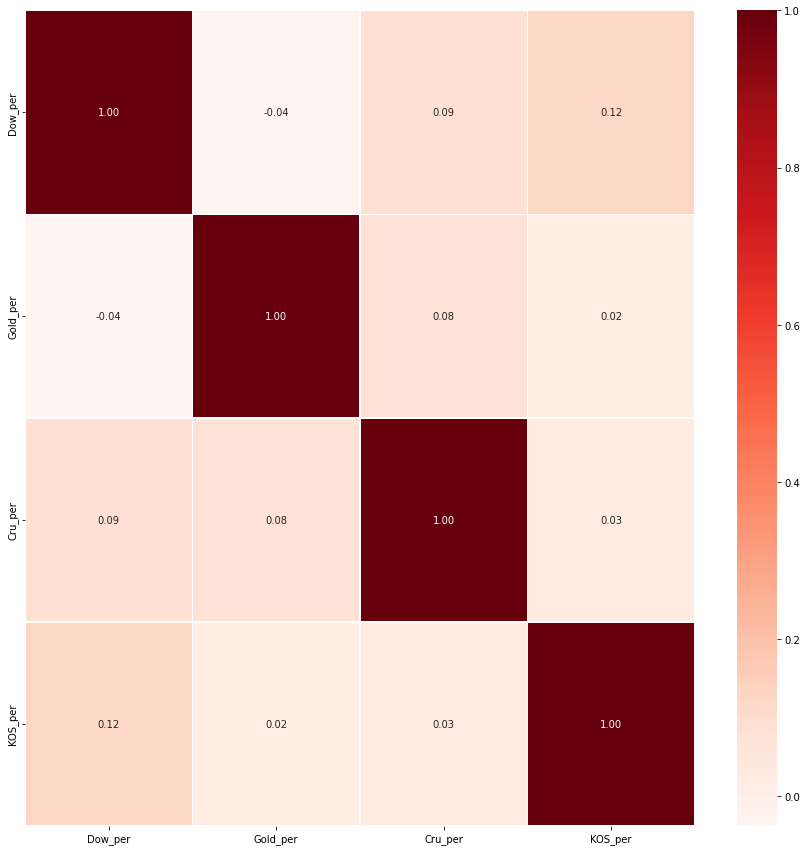

In [51]:
plt.figure(figsize=(15,15))
sns.heatmap(data = percentage.corr(), annot=True, #수치표현O  
fmt = '.2f', #소수 두번째자리까지 표현
linewidths=.5,
cmap='Reds')

===>상승률의 단순 비교로는 각 지수값과의 상관관계가 거의 없는것을 확인 할 수 있다.

그렇다면 각 상품별 close 가격을 기준으로는 어떨까?

# **가설2. 주요 상품들의 가격추이가 KOSPI 수치에 영향을 미칠까?**


해당 데이터는 수치형 데이터이자 연속형 데이터이기 때문에 회귀문제로 접근해보고자 한다. 이에 앞서 베이스 모델(평균값(mean))을 통해 데이터를 확인해보면

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

dow_price=pd.DataFrame(data['Dow_C'])
gol_price=pd.DataFrame(data['Gold_C'])
cru_price=pd.DataFrame(data['Cru_C'])
kos_price=pd.DataFrame(data['KOS_C'])

#전일대비 close 칼럼만 따로 취합 후 형변환
c_price=pd.concat([dow_price, gol_price, cru_price, kos_price], axis=1)
c_price.replace(to_replace=',', value='', regex=True, inplace=True)
c_price=c_price.astype(np.float)

#0인 값들은 전부 제거
c_price = c_price.replace(to_replace='0.00', value=np.NaN, regex=True)
c_price = c_price.dropna()

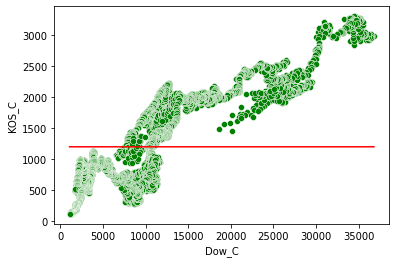

In [8]:
x = c_price['Dow_C']
y = c_price['KOS_C']
y_base=c_price['KOS_C'].mean()

predict = c_price['KOS_C'].mean()
errors = predict - c_price['Dow_C']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='green');

In [134]:
y_pred1=0*c_price['Dow_C']+y_base
y = c_price['KOS_C']
r2 = r2_score(y, y_pred1)
mse = mean_squared_error(y, y_pred1)
mae = mean_absolute_error(y, y_pred1)
rmse = mse ** 0.5

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,5.594442e+05
1,MAE,6.547783e+02
2,RMSE,7.479600e+02
3,R2,-2.220446e-16


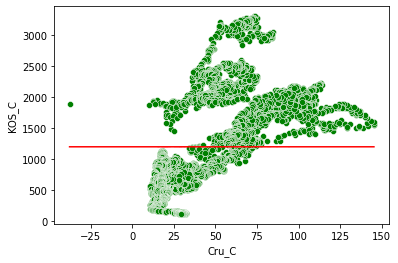

In [10]:
x = c_price['Cru_C']

errors = predict - c_price['Cru_C']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='green');

In [135]:
y_pred2=0*c_price['Cru_C']+y_base
y_pred2
r2 = r2_score(y, y_pred2)
mse = mean_squared_error(y, y_pred2)
mae = mean_absolute_error(y, y_pred2)
rmse = mse ** 0.5

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,5.594442e+05
1,MAE,6.547783e+02
2,RMSE,7.479600e+02
3,R2,-2.220446e-16


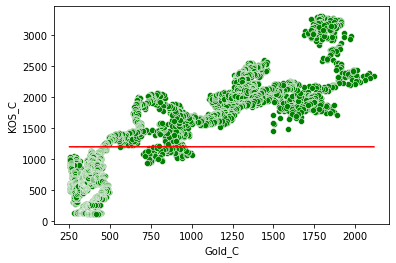

In [12]:
x = c_price['Gold_C']

errors = predict - c_price['Gold_C']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='green');

In [137]:
y_pred3=0*c_price['Gold_C']+y_base
y_pred3
r2 = r2_score(y, y_pred3)
mse = mean_squared_error(y, y_pred1)
mae = mean_absolute_error(y, y_pred1)
rmse = mse ** 0.5

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,5.594442e+05
1,MAE,6.547783e+02
2,RMSE,7.479600e+02
3,R2,-2.220446e-16


BaseModel로는 에러가 상당히 크고 상관관계가 거의 없기 때문에 이에 대해 시각적으로 다시 확인해보고자 한다.

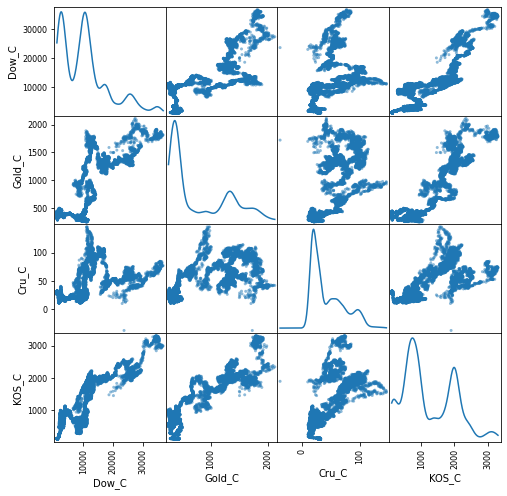

In [56]:
from pandas.plotting import scatter_matrix

#산점도 행렬
scatter_matrix(c_price, 
               alpha=0.5, 
               figsize=(8, 8), 
               diagonal='kde')
plt.show()

=>>산점도 행렬을 통해 KOSPI 지수는 Dow와 Gold에서 더 강한 선형관계에 있음을 확인할 수 있다.  
산점도행렬의 왼쪽 대각선으로 이어진 kde에 대한 설명은 아래를 참고하면 된다.

https://darkpgmr.tistory.com/147

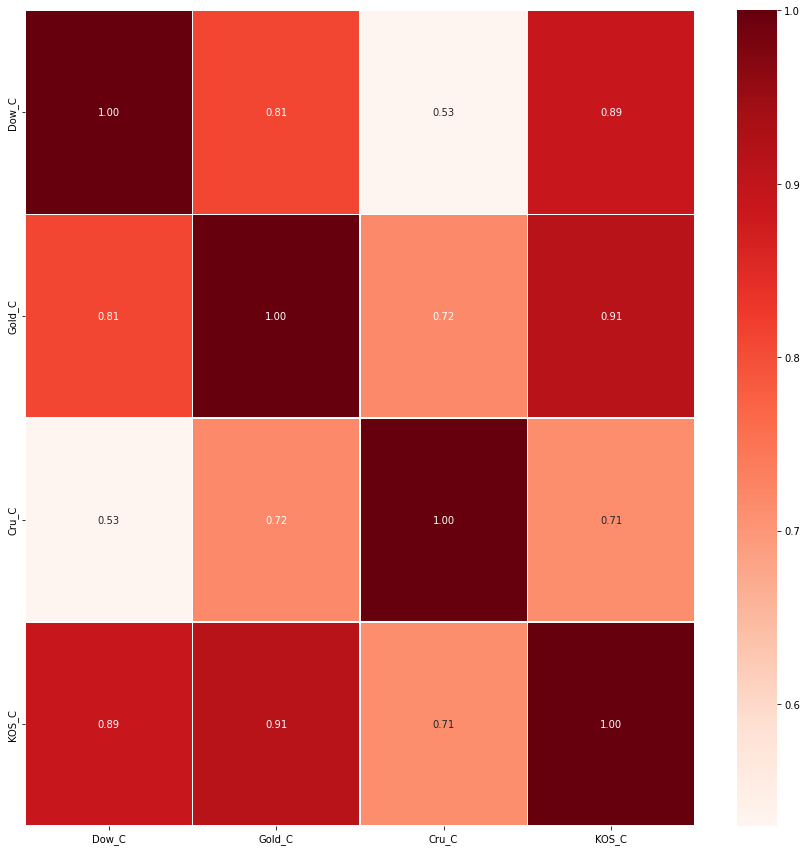

In [57]:
plt.figure(figsize=(15,15))
sns.heatmap(data = c_price.corr(), annot=True, #수치표현O  
fmt = '.2f', #소수 두번째자리까지 표현
linewidths=.5,
cmap='Reds')

상관계수가 높은 순으로는 

1. Gold
2. DowJones
3. Crude oil

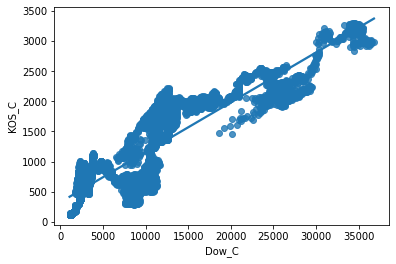

In [58]:
sns.regplot(x=c_price['Dow_C'], y=c_price['KOS_C']);

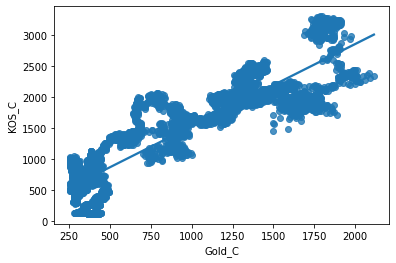

In [59]:
sns.regplot(x=c_price['Gold_C'], y=c_price['KOS_C']);

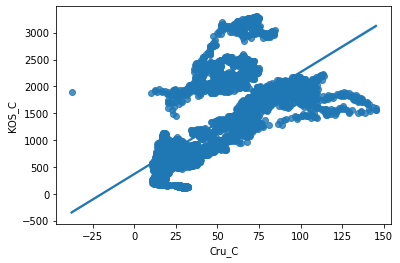

In [60]:
sns.regplot(x=c_price['Cru_C'], y=c_price['KOS_C']);

**KOSPI지수가 각 상품별 close 가격에서 선형관계에 가깝다는 것을 확인했으므로** **선형회귀모델을 통해 학습을 진행해보려고 한다.** 

(상관계수가 높은 두 특성만 진행)

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
model = LinearRegression()

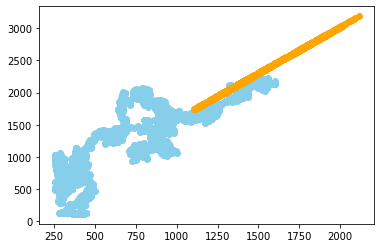

In [78]:
feature = ['Gold_C']
target = ['KOS_C']
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_train, y_train, color='skyblue', linewidth=1)
plt.scatter(X_test, y_pred, color='orange', linewidth=1);

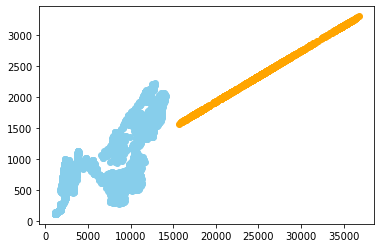

In [79]:
feature2 = ['Dow_C']
target = ['KOS_C']
X_train2 = train[feature2]
y_train2 = train[target]
X_test2 = test[feature2]
y_test2 = test[target]

model.fit(X_train2, y_train)

y_pred = model.predict(X_test2)

plt.scatter(X_train2, y_train, color='skyblue', linewidth=1)
plt.scatter(X_test2, y_pred, color='orange', linewidth=1);

In [80]:
target = 'KOS_C'
features = c_price.columns.drop('KOS_C')

test = c_price[:1500]
val = c_price[1500:2500]
train = c_price[2500:]

test.shape, train.shape

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]



In [298]:
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_test, y_test))

R^2 0.6492396285144959


In [82]:
linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_test, y_test))

R^2 -1.0025984522613647


In [83]:
print(model.coef_)  #선형모델의 계수
print(model.intercept_)    #선형모델의 절편

[[0.08201423]]
[290.6920408]


In [84]:
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Dow_C     0.047704
Gold_C    1.038922
Cru_C     1.180092
dtype: float64

KOSPI지수와의 관계에서 선형에 가까운 DOWJONES 지수와 GOLD 상품의 가격을 기준으로 해석해 보면, 

***KOSPI 지수가 100p 증가할 때, DOWJONES 지수는 4p 상승하고,**

***KOSPI 지수가 10p 증가할 때, GOLD 가격이 10만큼 상승하는 것을 알 수 있다.**

하지만 R2지수가 형편없는 것을 확인할 수 있어 Ridge 회귀학습을 진행하고자 한다.

**Ridge 회귀모델로 학습한 결과는 어떻게 다른지 진행해 보면**

In [224]:
test = c_price[:2000]
train = c_price[2000:]

test.shape, train.shape

((2000, 4), (7216, 4))

In [225]:
target = 'KOS_C'
features = c_price.columns.drop(['KOS_C'])

In [226]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Ridge Regression, alpha=0.001
Test MAE: $178
Test R2: 0.650


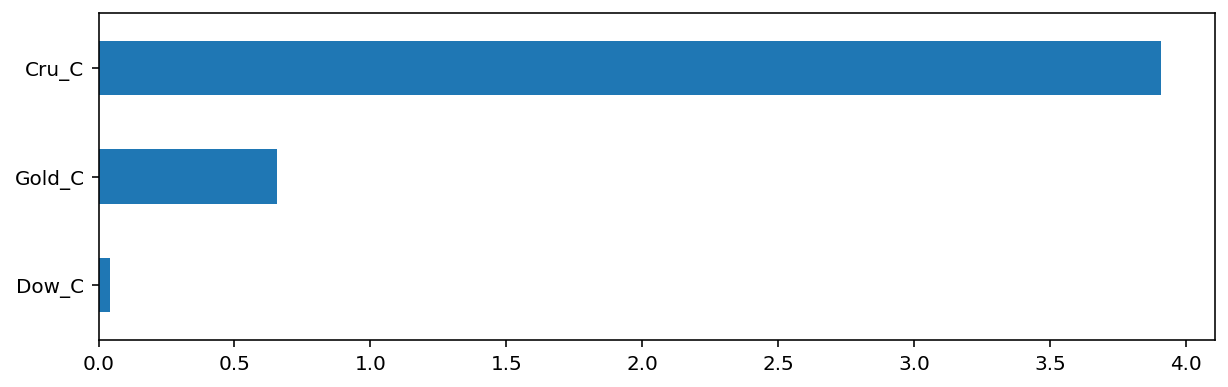

Ridge Regression, alpha=0.005
Test MAE: $178
Test R2: 0.654


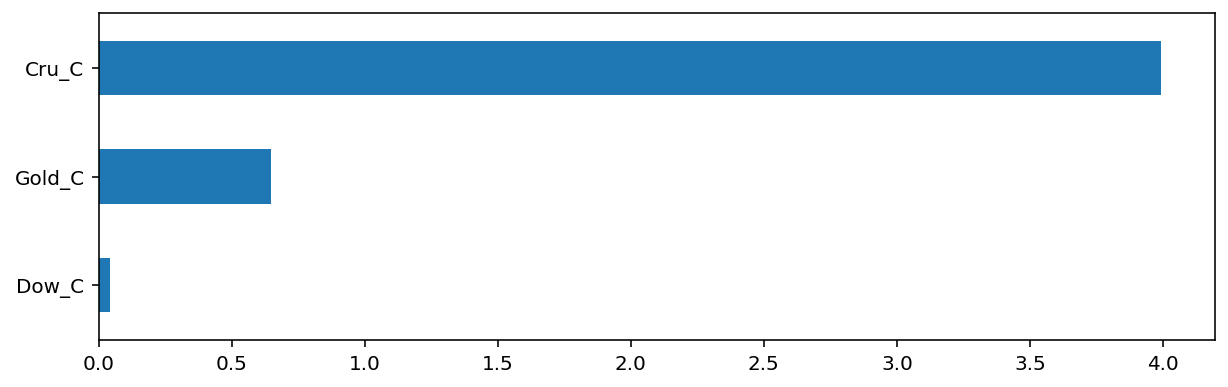

Ridge Regression, alpha=0.01
Test MAE: $179
Test R2: 0.657


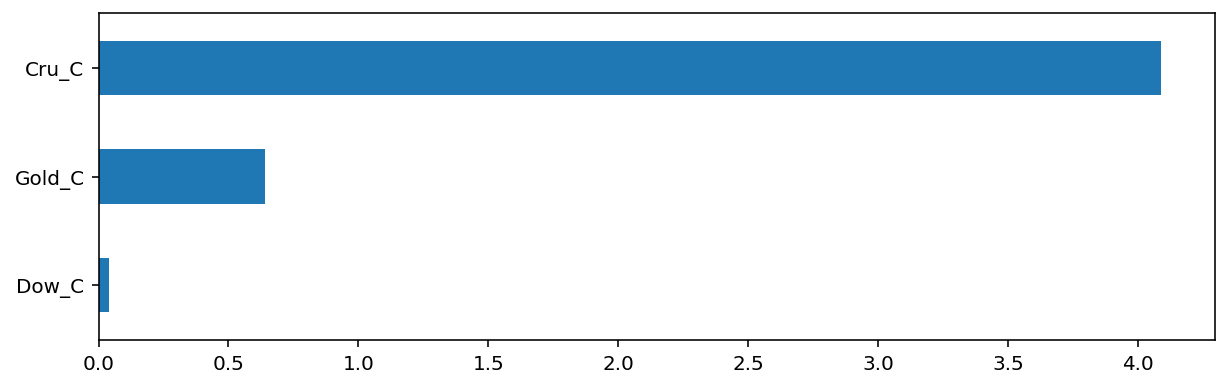

Ridge Regression, alpha=0.02
Test MAE: $181
Test R2: 0.658


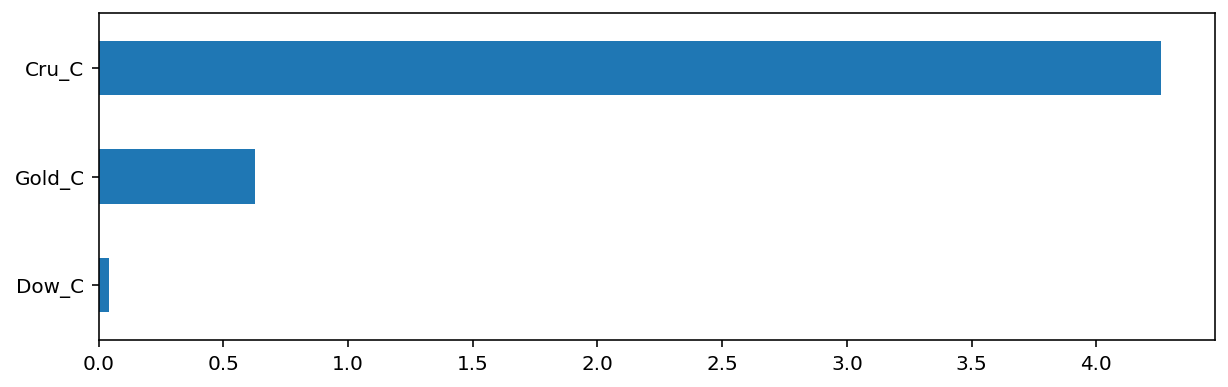

Ridge Regression, alpha=0.03
Test MAE: $183
Test R2: 0.654


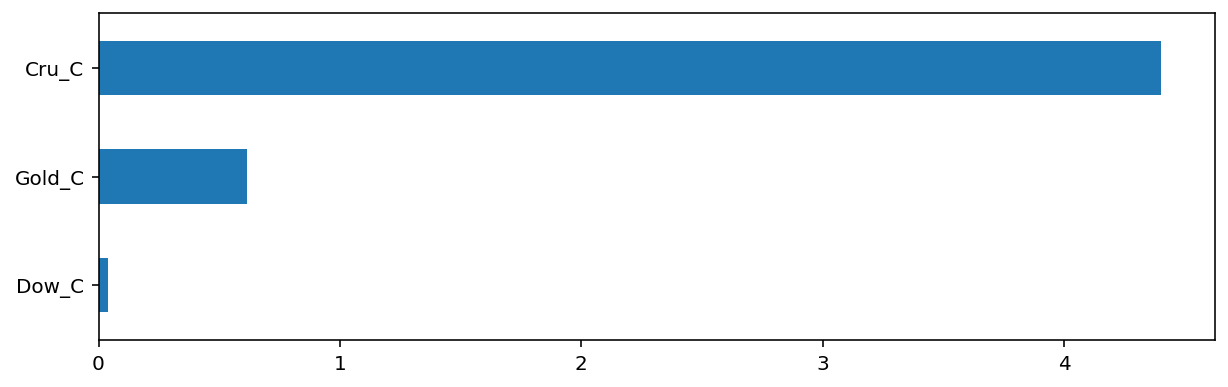

Ridge Regression, alpha=0.1
Test MAE: $204
Test R2: 0.576


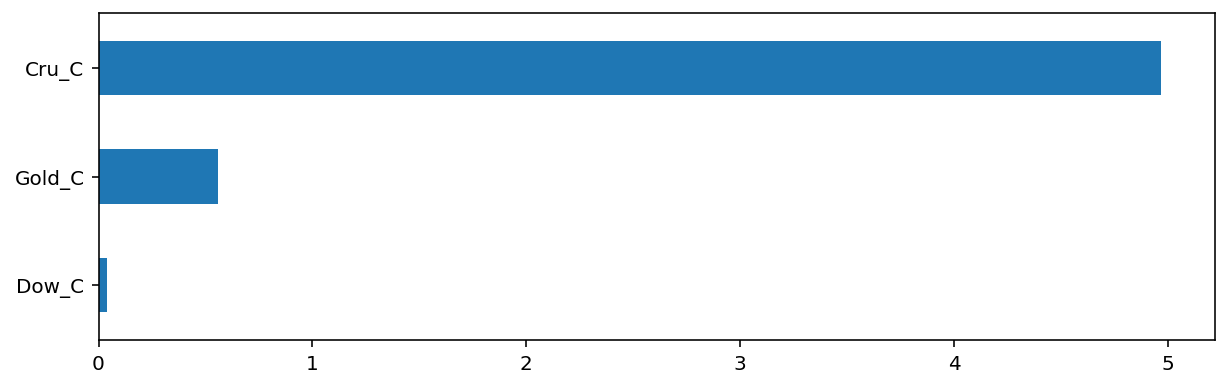

Ridge Regression, alpha=1.0
Test MAE: $488
Test R2: -1.081


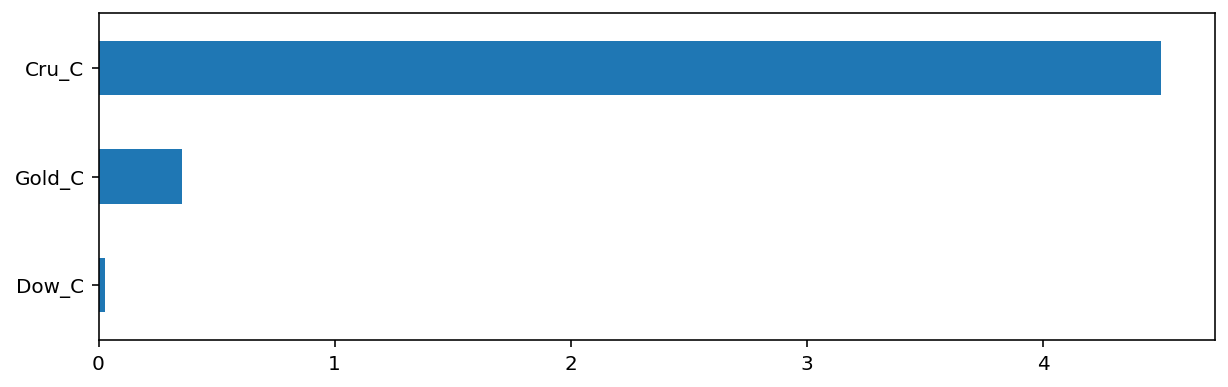

Ridge Regression, alpha=1
Test MAE: $488
Test R2: -1.081


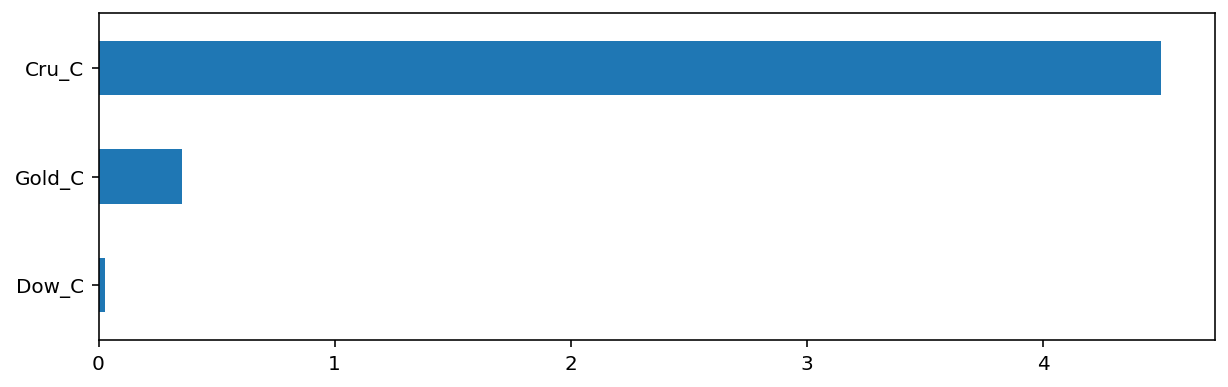

Ridge Regression, alpha=100.0
Test MAE: $1,309
Test R2: -12.361


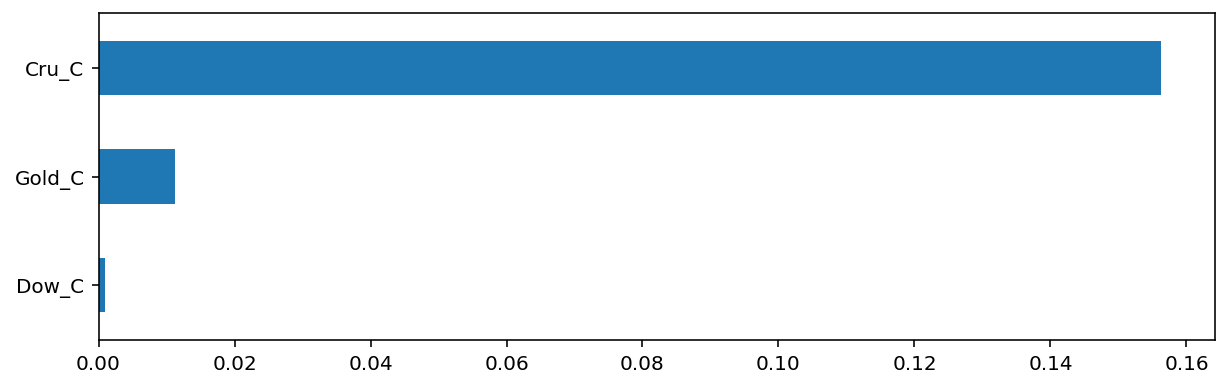

Ridge Regression, alpha=1000.0
Test MAE: $1,335
Test R2: -12.873


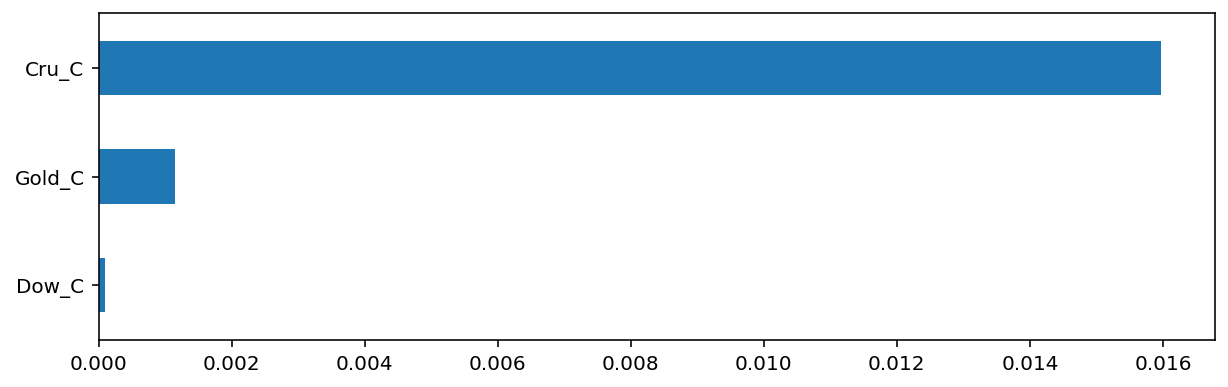

In [227]:
from sklearn.metrics import r2_score

for alpha in [0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 1.0, 1, 100.0, 1000.0]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2:,.3f}')
    
    # plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(10,3))
    coefficients.sort_values().plot.barh()
    plt.show()

In [228]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def RidgeRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         Ridge(**kwargs))


for alpha in [0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 1.0, 1, 100.0, 1000.0]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = RidgeRegression(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'R2 Score: {r2:,.4f}\n')

coefs = model.named_steps["ridge"].coef_
print(f'Number of Features: {len(coefs)}')

Ridge Regression, alpha=0.001
Test MAE: $1,599
R2 Score: -30.1601

Ridge Regression, alpha=0.005
Test MAE: $2,666
R2 Score: -92.8204

Ridge Regression, alpha=0.01
Test MAE: $2,092
R2 Score: -58.6302

Ridge Regression, alpha=0.02
Test MAE: $1,389
R2 Score: -25.6549

Ridge Regression, alpha=0.03
Test MAE: $1,001
R2 Score: -12.7514

Ridge Regression, alpha=0.1
Test MAE: $204
R2 Score: 0.6020

Ridge Regression, alpha=1.0
Test MAE: $707
R2 Score: -6.4230

Ridge Regression, alpha=1
Test MAE: $707
R2 Score: -6.4230

Ridge Regression, alpha=100.0
Test MAE: $1,062
R2 Score: -7.5823

Ridge Regression, alpha=1000.0
Test MAE: $1,306
R2 Score: -12.2466

Number of Features: 20


In [235]:
X_total = pd.concat([X_train, X_test])
y_total = pd.concat([y_train, y_test])

In [236]:
coefs.max(), coefs.mean()

(0.01576486558903874, 0.0008567927719573653)

In [237]:
coefs.sort()

In [238]:
coefs

array([0.00000000e+00, 5.15916960e-13, 5.74296110e-12, 4.37248812e-11,
       8.27109880e-11, 3.13663842e-10, 7.61801099e-10, 5.78531849e-09,
       6.69349182e-09, 1.02463146e-08, 7.93427512e-08, 9.51475510e-08,
       5.65830233e-07, 1.09247657e-06, 1.11969204e-06, 9.97041067e-06,
       9.34827424e-05, 1.30280486e-04, 1.13427979e-03, 1.57648656e-02])

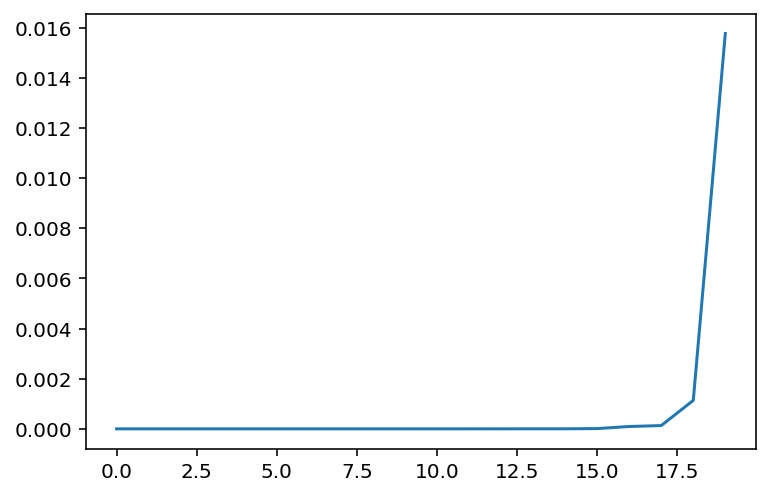

In [239]:
plt.plot(coefs)

In [240]:
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True)
    , SimpleImputer()
    , StandardScaler()
    , SelectKBest(f_regression)
    , Ridge()
)

dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=500, 
    cv=100,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 100 folds for each of 18 candidates, totalling 1800 fits


In [241]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'selectkbest__k': 3, 'ridge__alpha': 10}
MAE:  198.24100743278558


In [242]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,17,16,11,10,4,5,15,14,9,8,3,2,1,0,6,7,12,13
mean_fit_time,0.0162261,0.0132179,0.0164946,0.0135912,0.0137904,0.0165771,0.0169865,0.0136408,0.0164438,0.0133915,0.0166666,0.0144307,0.0178086,0.0144532,0.0142347,0.0168838,0.0132562,0.016448
std_fit_time,0.00403744,0.00402009,0.00467038,0.00526071,0.00505086,0.00493583,0.00601062,0.00478491,0.00500065,0.00392092,0.00514835,0.00484764,0.00588602,0.00422606,0.00545544,0.00576912,0.00403963,0.00498293
mean_score_time,0.00389092,0.00399013,0.00390564,0.00403546,0.00401238,0.00393359,0.00406136,0.00405679,0.00397487,0.00425583,0.00379466,0.00432764,0.00431971,0.0041907,0.00428661,0.0040101,0.0041565,0.00411186
std_score_time,0.00131973,0.00102861,0.000782148,0.00105644,0.000938763,0.000846804,0.00148338,0.00126018,0.00117247,0.00163707,0.000454222,0.00183309,0.00178016,0.00128282,0.00200603,0.0011545,0.00137273,0.00157475
param_simpleimputer__strategy,median,mean,median,mean,mean,median,median,mean,median,mean,median,mean,median,mean,mean,median,mean,median
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
split98_test_score,-429.529,-429.529,-429.032,-429.032,-428.982,-428.982,-637.559,-637.559,-637.469,-637.469,-637.46,-637.46,-666.045,-666.045,-666.062,-666.062,-666.227,-666.227
split99_test_score,-433.007,-433.007,-432.553,-432.553,-432.507,-432.507,-637.797,-637.797,-637.696,-637.696,-637.686,-637.686,-653.024,-653.024,-653.042,-653.042,-653.217,-653.217
mean_test_score,-198.241,-198.241,-198.301,-198.301,-198.307,-198.307,-203.145,-203.145,-203.186,-203.186,-203.19,-203.19,-228.059,-228.059,-228.063,-228.063,-228.099,-228.099
std_test_score,119.022,119.022,118.977,118.977,118.973,118.973,163.577,163.577,163.556,163.556,163.553,163.553,168.42,168.42,168.415,168.415,168.364,168.364


In [243]:
pipe = clf.best_estimator_

In [244]:
from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print('테스트 데이터평가')
display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))


테스트 데이터평가


,Metric,Score
0,MSE,48317.581880
1,MAE,177.814981
2,RMSE,219.812606
3,R2,0.650714


In [245]:
!pip install PDPbox
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

feature1 = 'Gold_C'
feature2 = 'Dow_C'

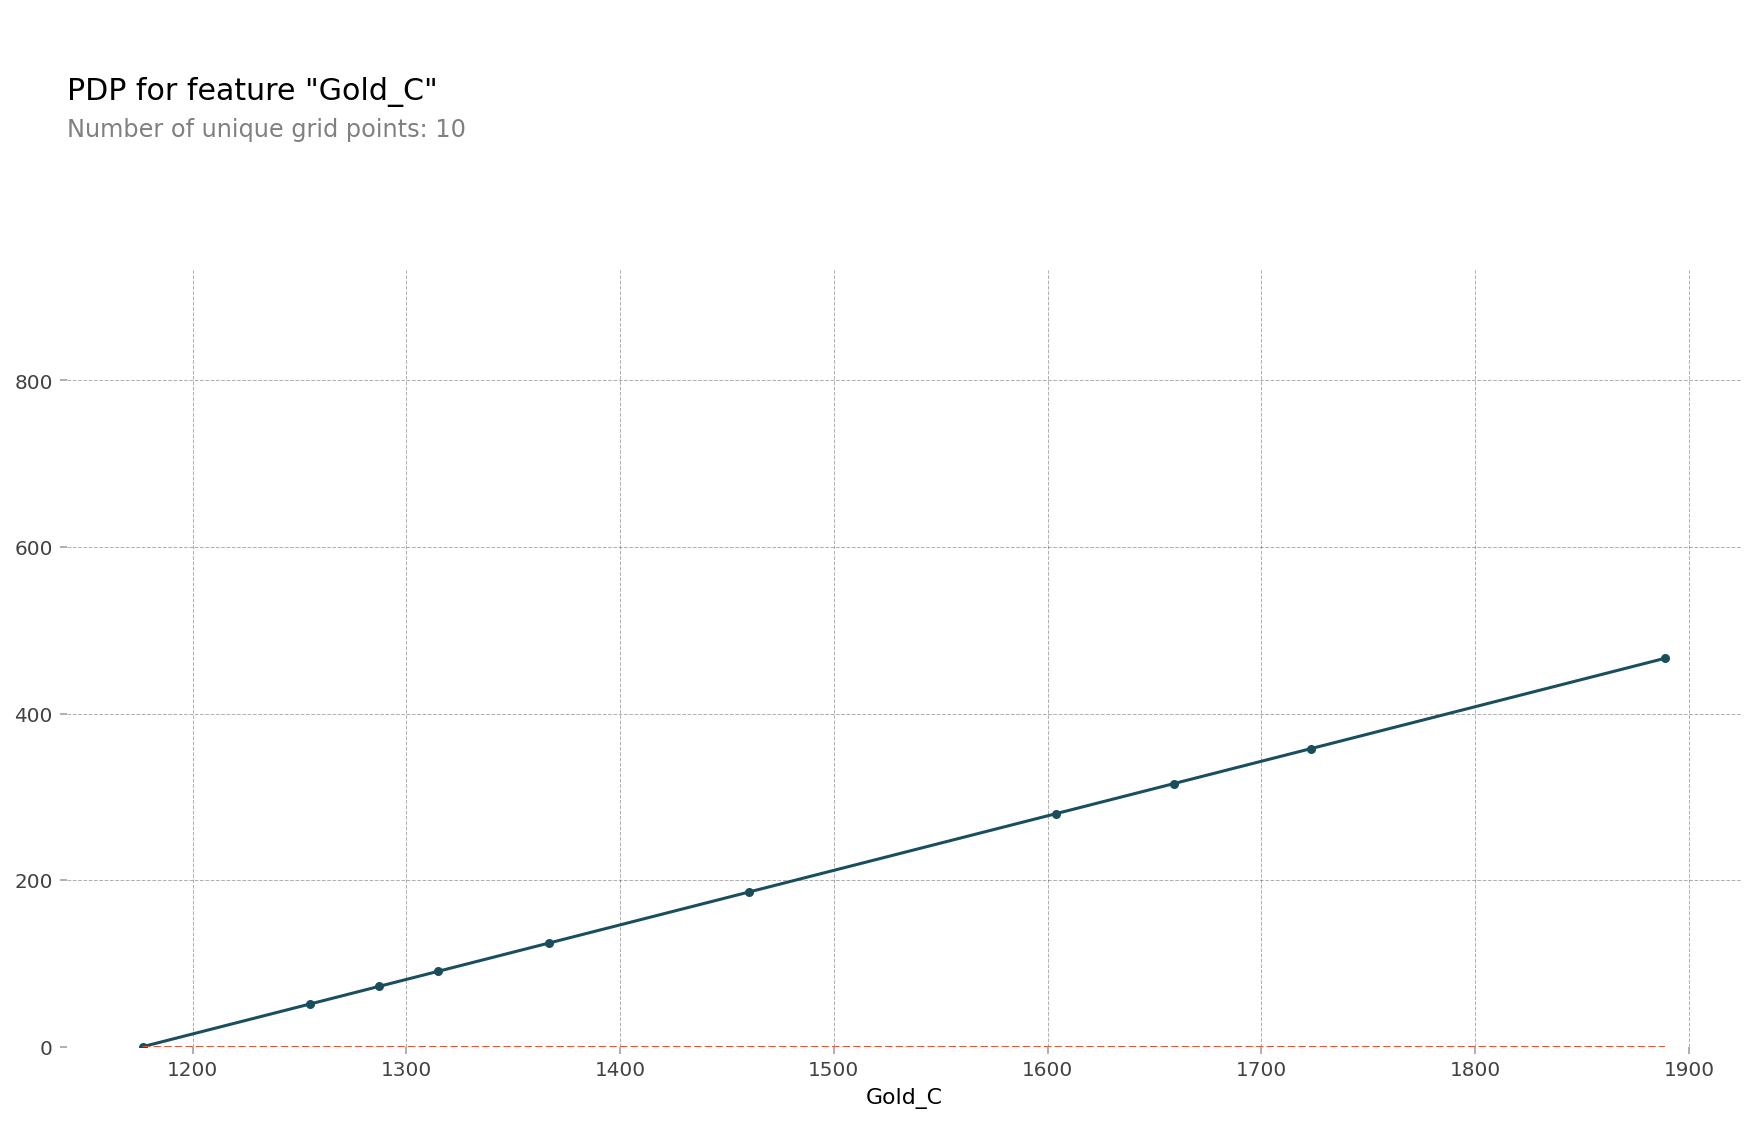

In [246]:
isolated = pdp_isolate(
    model=clf, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature1,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [247]:

isolated = pdp_isolate(
    model=clf, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature2
)

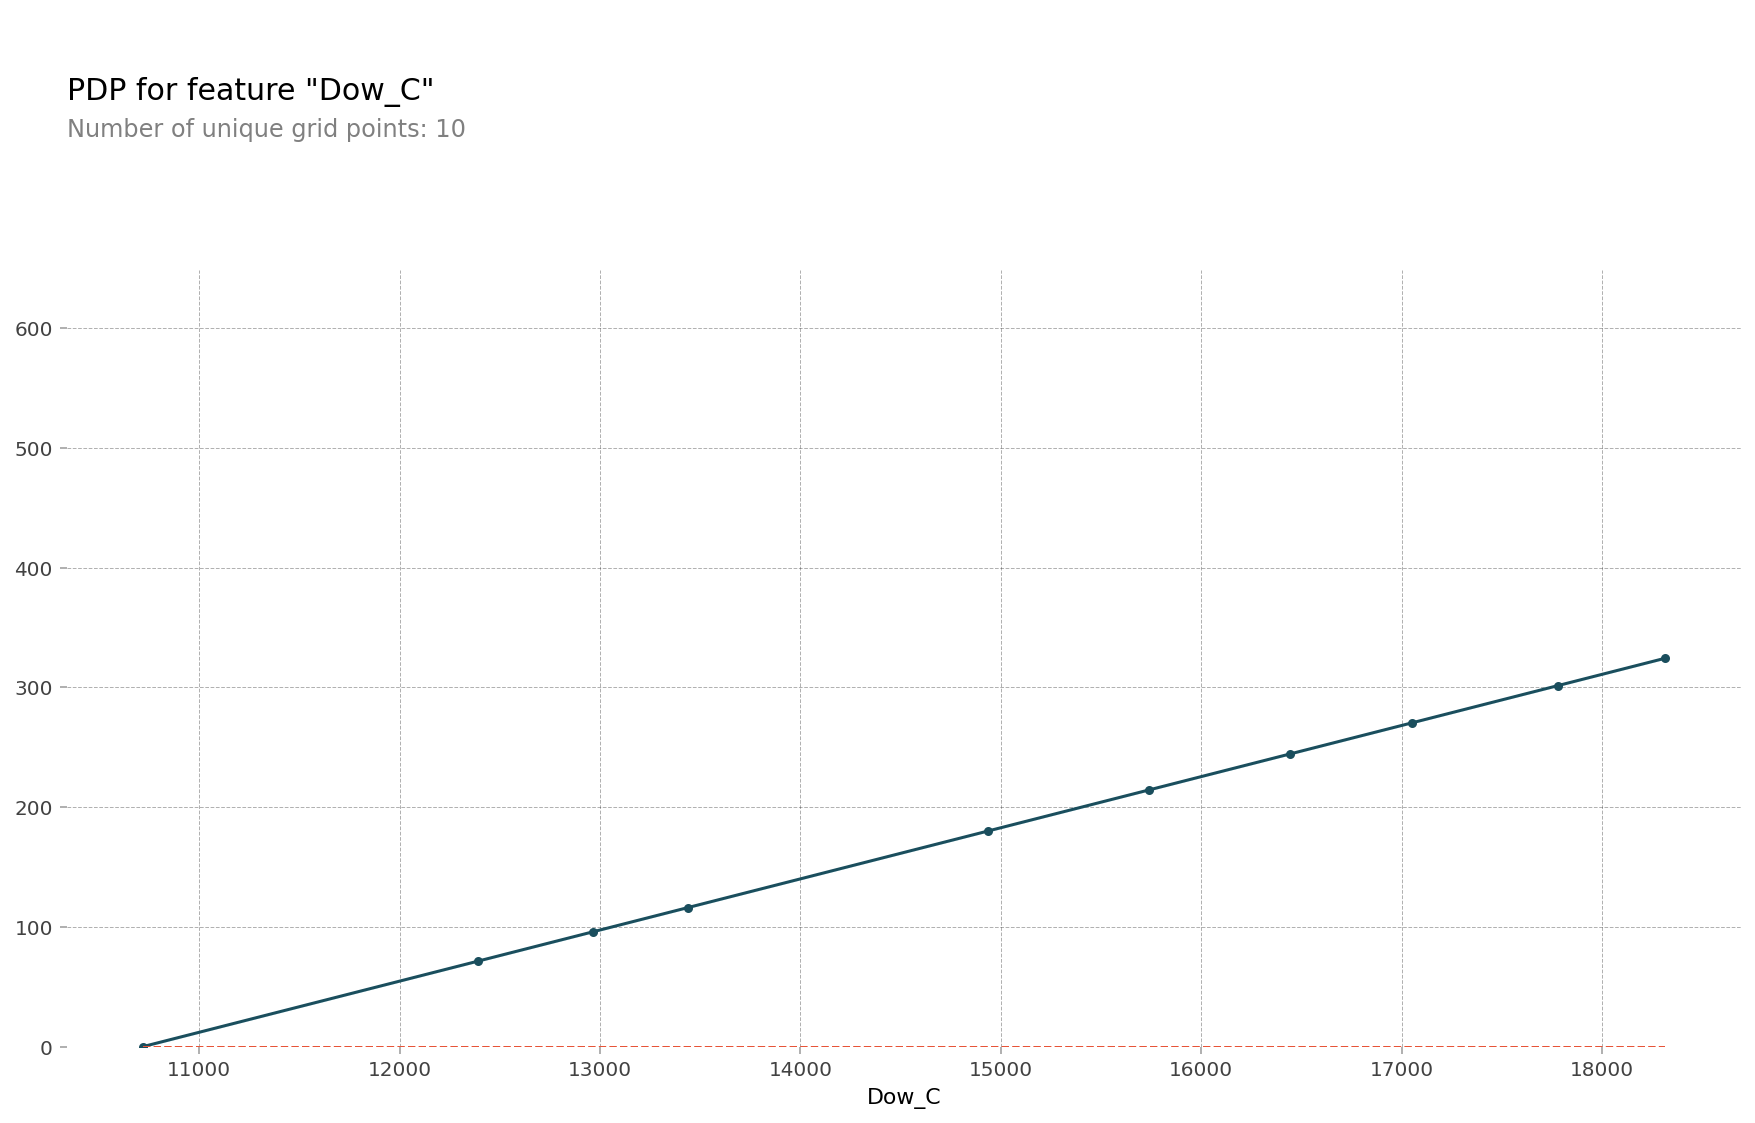

In [248]:
pdp_plot(isolated, 
         feature_name=feature2,
         plot_pts_dist=False);


In [249]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [250]:
features = ['Gold_C', 'Dow_C']

interaction = pdp_interact(
    model=clf, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

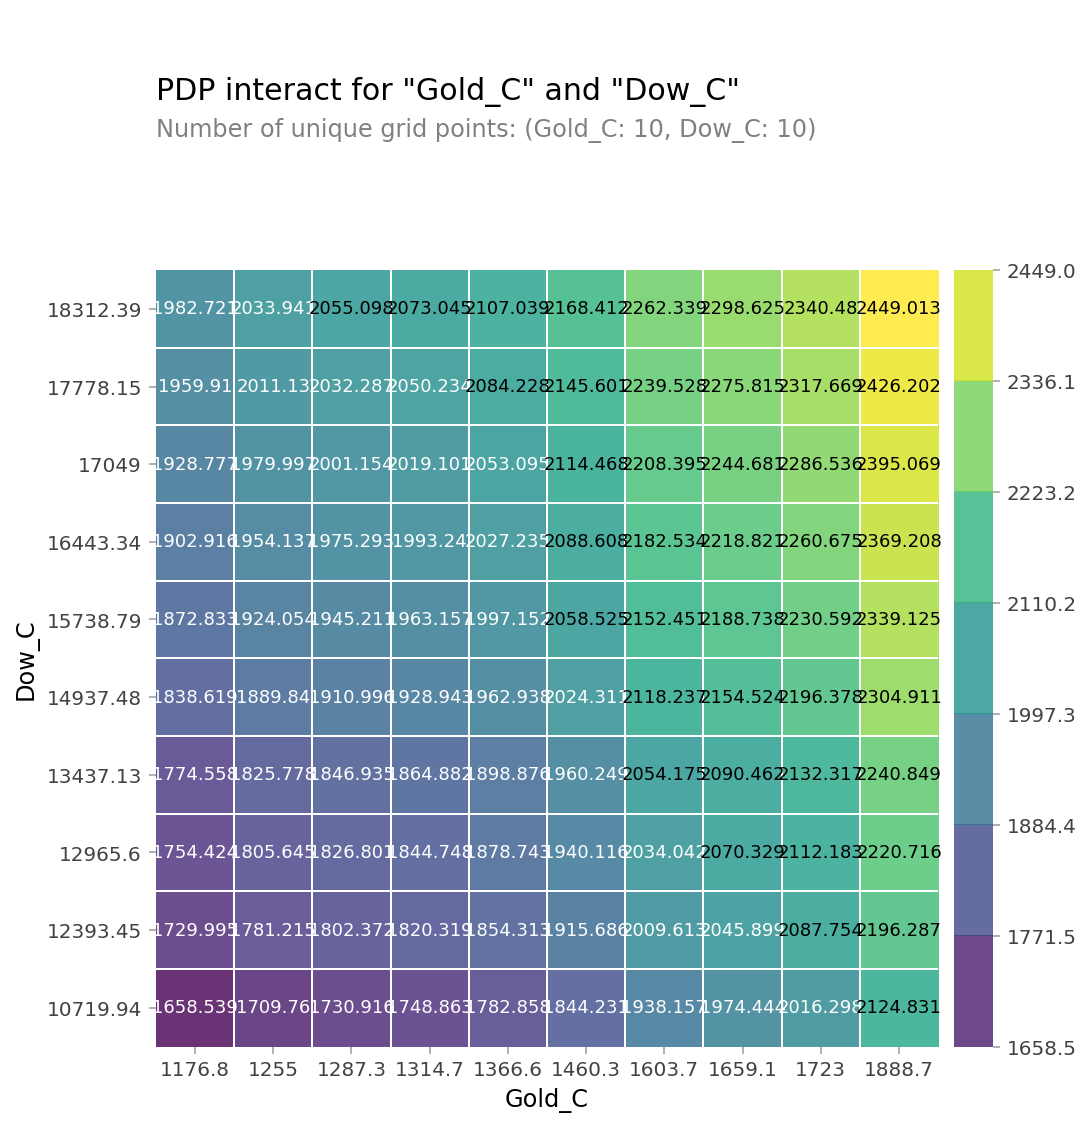

In [251]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [252]:
# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1] # 인덱스를 역순으로 만드는 slicing입니다

In [253]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

In [254]:
row = X_test.iloc[[1]] 
row

,Dow_C,Gold_C,Cru_C
1,36407.3,1825.1,77.85


In [255]:
#실제 KOSPI지수
y_test.iloc[[1]] 

1    2953.97
Name: KOS_C, dtype: float64

In [256]:
model.predict(row)

array([4880921.76188412])

In [272]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, 30, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [301]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE: ', -search.best_score_)
model = search.best_estimator_


최적 하이퍼파라미터:  {'max_depth': 10, 'max_features': 0.7466314080892297, 'n_estimators': 147}
CV MAE:  130.92075329518443


In [311]:
!pip install shap
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [316]:
row = X_test.iloc[[1000]]

In [317]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

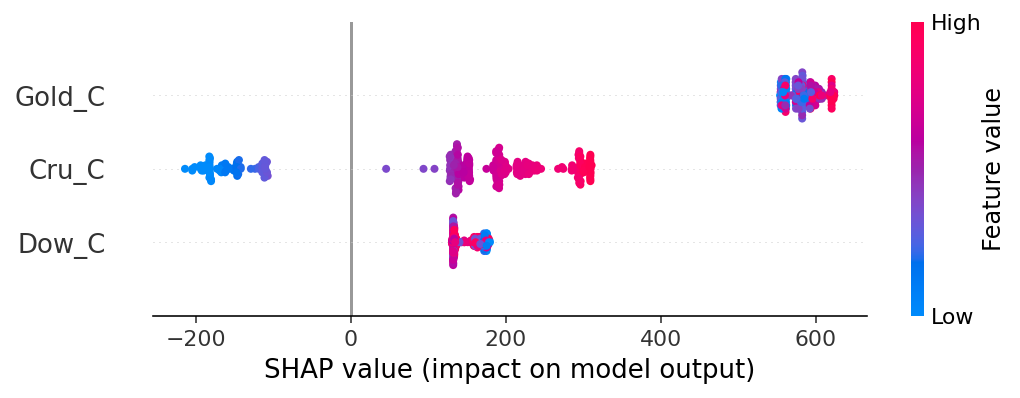

In [294]:
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_test.iloc[:300])

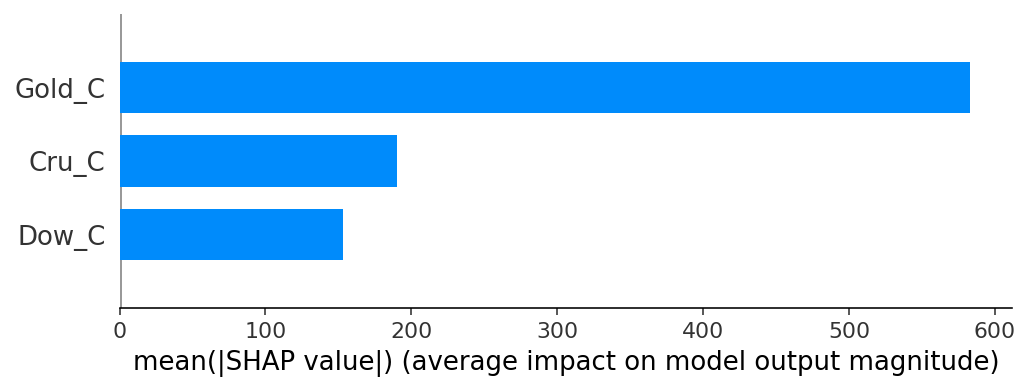

In [280]:
shap.summary_plot(shap_values, X_test.iloc[:300], plot_type="bar")